In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pf import *

In [2]:
SIZE_X = 100
SIZE_Y = 100

true_position = Position(50, 10, 1.5)

In [3]:
def plot_pf_img(pf):
    # DEPRECATED
    img = np.zeros([SIZE_Y, SIZE_X])
    for particle in pf.particles:
        img[int(particle.y)][int(particle.x)] = particle.weight

    plt.imshow(img, cmap='gray')
    plt.colorbar()

def plot_pf_qvr(pf, true_position=None):
    for particle in pf.particles:
        # print(particle.x, particle.y, particle.theta, particle.weight)
        plt.quiver(particle.x, particle.y, particle.weight*math.cos(particle.theta), particle.weight*math.sin(particle.theta), width=0.005, scale=20)
    if true_position is not None:
        plt.quiver(true_position.x, true_position.y, math.cos(true_position.theta), math.sin(true_position.theta), width=0.005, scale=20, color='r')
    plt.ylim(0, SIZE_Y)
    plt.xlim(0, SIZE_X)
    plt.show()


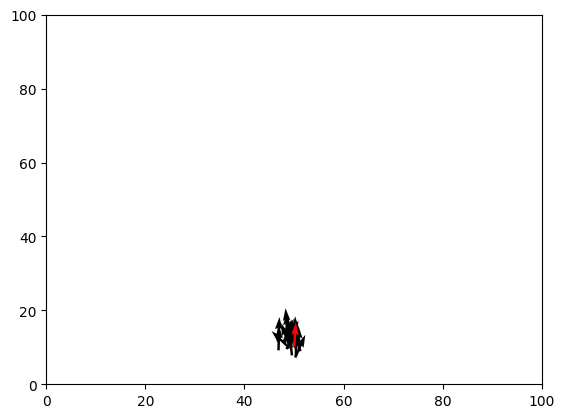

In [4]:
pf = PF(true_position, 20, 1.5, .3)
plot_pf_qvr(pf, true_position)

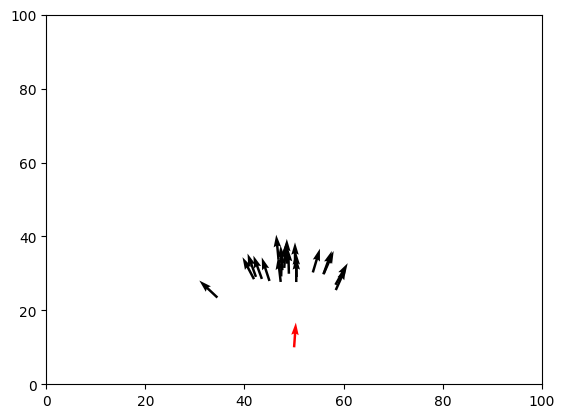

In [6]:
pf.propagate_odom(10, 0)
update_pos(true_position, 10, 0)
plot_pf_qvr(pf, true_position)